In [1]:
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo

In [2]:
# automatically download data 
stationIDs = {'Baltimore': 'USW00093784',}
import ulmo
st = ulmo.ncdc.ghcn_daily.get_stations(country='US', as_dataframe=True)
#st[st.name.str.contains('BIRMINGHAM')]

In [4]:
stationlist = np.array([('BALTIMORE', 'urban', 'USW00093784'),
        ('BALTIMORE', 'rural', 'USW00093721'),
        ('SAN FRANCISCO', 'urban', 'USW00023272') , 
        ('SAN FRANCISCO', 'rural', 'USW00023234'), # airport
        ('SEATTLE', 'rural', 'USW00024233'), #seatac
        ('SEATTLE', 'urban', 'USW00094290'), #sandpoint
        ('BIRMINGHAM', 'urban', 'USW00013876'), #airport
        ('BIRMINGHAM', 'rural', 'USC00011225'),# pumphouse  'USW00003883'), #
        ('CHICAGO', 'urban', 'USW00014819'), #midway
        ('CHICAGO', 'rural', 'USC00112736')])
df = pd.DataFrame(stationlist, columns = ['city', 'type', 'number'])
df = df.set_index(df.number)

In [5]:
df.city.unique()

array(['BALTIMORE', 'SAN FRANCISCO', 'SEATTLE', 'BIRMINGHAM', 'CHICAGO'], dtype=object)

In [2]:
stationlist = np.array([('Baltimore', 'urban', 'USW00093784'),
        ('Baltimore', 'rural', 'USW00093721'),
        ('Birmingham', 'urban', 'USW00013876'), 
         ('Birmingham', 'rural', 'USW00003883')])
df = pd.DataFrame(stationlist, columns = ['city', 'type', 'number'])
df = df.set_index(df.number)

In [9]:
for city in df.city.unique(): 
    print str(df[df.city==city][df.type=='urban'].index[0])

USW00093784
USW00013876


In [13]:
# List all the stations, their type (urban/rural), and their station ID to download from the NCDC ftp site
stationlist = np.array([('Baltimore', 'urban', 'USW00093784'),
        ('Baltimore', 'rural', 'USW00093721') ])
#         ('Birmingham', 'urban', 'USW00013876'), 
#          ('Birmingham', 'rural', 'USW00003883')])
df = pd.DataFrame(stationlist, columns = ['city', 'type', 'number'])
df = df.set_index(df.number)

for city in df.city.unique(): 
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(str(df[df.city==city][df.type=='urban'].index[0]),
                                         as_dataframe=True)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(str(df[df.city==city][df.type=='rural'].index[0]),
                                         as_dataframe=True)
    
    # Probably want to cut off at some year here!!!
    
    # Calculate minimum daily thresholds
    tmin = pd.to_numeric(ruraldata['TMIN'].value/10.) 
    filename = './data/mindailytempthresholds'+city+ '.npy'
    if os.path.isfile(filename): 
        minthresh = np.load(filename)
    else: 
        summary = tmin.groupby(tmin.index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
        ninetieth = summary.values[5::10]
        ninetyfifth = summary.values[6::10]
        ninetyeigth = summary.values[7::10]
        ninetyninth = summary.values[8::10]
        minthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
        np.save(('./data/mindailytempthresholds'+city), minthresh)

    # Calculate maximum  daily thresholds
    tmax = pd.to_numeric(ruraldata['TMAX'].value/10.) 
    filename = './data/maxdailytempthresholds'+city+ '.npy'
    if os.path.isfile(filename): 
        minthresh = np.load(filename)
    else: 
        summary = tmax.groupby(tmax.index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
        ninetieth = summary.values[5::10]
        ninetyfifth = summary.values[6::10]
        ninetyeigth = summary.values[7::10]
        ninetyninth = summary.values[8::10]
        maxthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
        np.save(('./data/maxdailytempthresholds'+city), maxthresh)
    
    numhw = 10 # number of heatwaves
    hottest = tmin.iloc[(-tmin.values).argsort()[:numhw]] #Get the hottest days based off tmin 
    hottesttmax = tmax.iloc[(-tmax.values).argsort()[:numhw]] 
    thresh = minthresh[:,3:]
    # check that these are heatwaves? Or just plot? 
    ind = np.where(hottest- thresh[0,hottest.index.dayofyear] >0)
    heatwaves = hottest.iloc[ind]
    # check that these last 48 hours
    ind2 = np.where(heatwaves- thresh[0,hottest.index.dayofyear+1] >0)[0]
    heatwaves = heatwaves[ind2]
    # check that they aren't the same event...
    
    #calculate UHI
    UHImin = pd.to_numeric(urbandata['TMIN'].value/10.) - tmin
    UHImax = pd.to_numeric(urbandata['TMAX'].value/10.) - tmax
    compositeTemp = np.zeros([heatwaves.shape[0], 11])
    compositeUHI = np.zeros([heatwaves.shape[0], 11])
    i = 0
    for dates in heatwaves.index[:]: 
        compositeUHI[i,:] = UHI[dates-pd.DateOffset(days=5):dates+pd.DateOffset(days=5)].values
        compositeTemp[i,:]= ruralDF.TEMP[dates-pd.DateOffset(days=5):dates+pd.DateOffset(days=5)].values
        i = i+1

    plt.figure(figsize=[12,4])
    plt.subplot(1,2,1)
    tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
    plt.plot(np.arange(-5,6,1),compositeTemp.mean(axis=0), linewidth = 3, color = 'black')
    #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
    plt.title('%s Temperature'%city)
    plt.ylabel('Temp. ($^\circ C$)')
    plt.xlabel('Heatwave Day')

    plt.subplot(1,2,2)    
    uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
    plt.plot(np.arange(-5,6,1),compositeUHI.mean(axis=0), linewidth = 3,color = 'black')
    plt.title('%s UHI'%city)
    plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
    plt.xlabel('Heatwave Day')
    plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

In [14]:
heatwaves

month_period
2010-07-24    27.8
2012-07-08    27.8
1949-07-28    27.2
2011-07-22    27.2
1952-06-26    26.7
1972-07-22    26.7
1940-07-21    26.7
1940-07-22    26.7
1940-07-26    26.7
2007-08-08    26.7
Freq: D, Name: value, dtype: float64

In [16]:
tmax.iloc[(-tmax.values).argsort()[:numhw]] 

month_period
2011-07-22    41.1
2010-07-06    40.6
1983-08-20    40.6
2012-07-07    40.0
1941-07-28    40.0
1988-07-16    40.0
2012-07-18    40.0
1988-08-15    39.4
2012-06-29    39.4
1980-07-16    38.9
Freq: D, Name: value, dtype: float64

In [3]:
# import data
files = glob.glob('../cityheat/Bmore/data/observations/urban/*.csv')
files.sort()
#urbanDF = pd.DataFrame(pd.read_csv(files[0], sep = ','))
frames = []
date_spec = {'Date': [2, 3, 4]}
#pd.read_csv(file, sep = ',') #, parse_dates = date_spec, keep_date_col=True)
for file in files:
    try :
        frames.append(pd.read_csv(file, sep = ',', parse_dates = date_spec, keep_date_col=True, index_col='Date'))
    except ValueError:
        print "oops... something went wrong"
urbanDF = pd.concat(frames, axis =0)

files = glob.glob('../cityheat/Bmore/data/observations/rural/*.csv')
files.sort()
#urbanDF = pd.DataFrame(pd.read_csv(files[0], sep = ','))
frames = []
date_spec = {'Date': [2, 3, 4]}
#pd.read_csv(file, sep = ',') #, parse_dates = date_spec, keep_date_col=True)
for file in files:
    try :
        frames.append(pd.read_csv(file, sep = ',', parse_dates = date_spec, keep_date_col=True, index_col='Date'))
    except ValueError:
        print "oops... something went wrong"
ruralDF = pd.concat(frames, axis =0)

ind  = urbanDF.index.intersection(ruralDF.index)
urbanDF = urbanDF.ix[ind]
ruralDF = ruralDF.ix[ind]

ruralDF = ruralDF[ruralDF < 1000]
urbanDF = urbanDF[urbanDF < 1000]

ruralDF.TEMP = ruralDF.TEMP.astype(float)
urbanDF.TEMP = urbanDF.TEMP.astype(float)

if ruralDF.TEMP.mean() > 30 : 
    ruralDF.TEMP = (ruralDF.TEMP-32.0)*5/9.
    urbanDF.TEMP = (urbanDF.TEMP-32.0)*5/9.

In [132]:
# calculate hw thresholds
# for city in cities: 
city = 'Baltimore'
df = ruralDF
# mean daily thresholds 
# data = df.TEMP[~np.isnan(df.TEMP) ].resample('D', how = 'mean')
# summary = data.groupby(data.index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
# ninetieth = summary.values[5::10]
# ninetyfifth = summary.values[6::10]
# ninetyeigth = summary.values[7::10]
# ninetyninth = summary.values[8::10]
# meandailytempthresholds = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
# save out 
#np.save('meandailytempthresholds', meandailytempthresholds)

# # min daily thresholds
data = df.TEMP[~ np.isnan(df.TEMP) ].resample('D', how = 'min')
summary = data.groupby(data.index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
ninetieth = summary.values[5::10]
ninetyfifth = summary.values[6::10]
ninetyeigth = summary.values[7::10]
ninetyninth = summary.values[8::10]
minthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
#np.save('mindailytempthresholds', mindailytempthresholds)

# # max daily thresholds
data = df.TEMP[~ np.isnan(df.TEMP) ].resample('D', how = 'max')
summary = data.groupby(data.index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
ninetieth = summary.values[5::10]
ninetyfifth = summary.values[6::10]
ninetyeigth = summary.values[7::10]
ninetyninth = summary.values[8::10]

maxthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
# np.save('maxdailytempthresholds', maxdailytempthresholds)

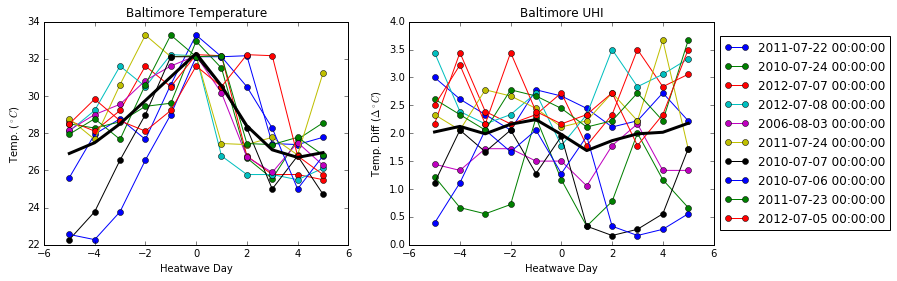

In [135]:
# find 
# Analyze heatwaves and UHI 
#minthresh = (np.load('mindailytempthresholds.npy') -32) *5/9.
# (minthresh[:, 3:]-32)*5/9.
# Find hottest days 
numhw = 10
#data = df.ruralDF.resample('D', how = 'min')
hottest = data.iloc[(-data.values).argsort()[:numhw]]

thresh = minthresh[:,3:]
# check that these are heatwaves? Or just plot? 
ind = np.where(hottest- thresh[0,hottest.index.dayofyear] >0)
heatwaves = hottest.iloc[ind]
# check that these last 48 hours
ind2 = np.where(heatwaves- thresh[0,hottest.index.dayofyear+1] >0)[0]
heatwaves = heatwaves[ind2]
# check that they aren't the same event...

#calculate UHI
UHI = urbanDF.TEMP- ruralDF.TEMP
compositeTemp = np.zeros([heatwaves.shape[0], 11])
compositeUHI = np.zeros([heatwaves.shape[0], 11])
i = 0
for dates in heatwaves.index[:]: 
    compositeUHI[i,:] = UHI[dates-pd.DateOffset(days=5):dates+pd.DateOffset(days=5)].values
    compositeTemp[i,:]= ruralDF.TEMP[dates-pd.DateOffset(days=5):dates+pd.DateOffset(days=5)].values
    i = i+1
    #plt.plot(np.arange(-5,6),event)
    
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),compositeTemp.mean(axis=0), linewidth = 3, color = 'black')
#plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
plt.title('%s Temperature'%city)
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.plot(np.arange(-5,6,1),compositeUHI.mean(axis=0), linewidth = 3,color = 'black')
plt.title('%s UHI'%city)
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

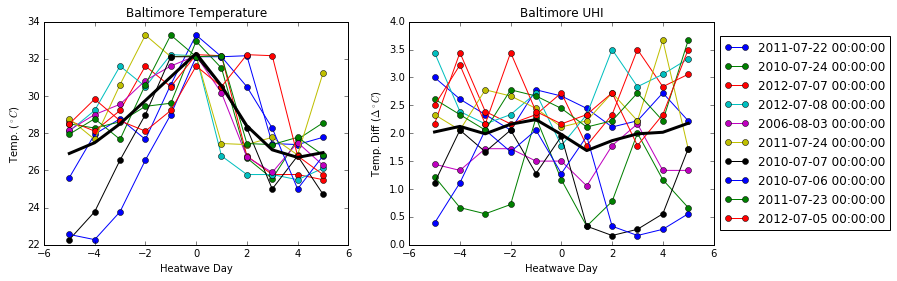

In [142]:
# find 
# Analyze heatwaves and UHI 
#minthresh = (np.load('mindailytempthresholds.npy') -32) *5/9.
# (minthresh[:, 3:]-32)*5/9.
# Find hottest days 
numhw = 10

hottest = data.iloc[(-data.values).argsort()[:numhw]]

thresh = maxthresh[2,3:]
# check that these are heatwaves? Or just plot? 
ind = np.where(hottest- thresh[hottest.index.dayofyear] >0)
heatwaves = hottest.iloc[ind]
# check that these last 48 hours
ind2 = np.where(heatwaves- thresh[hottest.index.dayofyear+1] >0)[0]
heatwaves = heatwaves[ind2]
# check that they aren't the same event...

#calculate UHI
UHI = urbanDF.TEMP- ruralDF.TEMP
compositeTemp = np.zeros([heatwaves.shape[0], 11])
compositeUHI = np.zeros([heatwaves.shape[0], 11])
i = 0
for dates in heatwaves.index[:]: 
    compositeUHI[i,:] = UHI[dates-pd.DateOffset(days=5):dates+pd.DateOffset(days=5)].values
    compositeTemp[i,:]= ruralDF.TEMP[dates-pd.DateOffset(days=5):dates+pd.DateOffset(days=5)].values
    i = i+1
    #plt.plot(np.arange(-5,6),event)
    
plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
plt.plot(np.arange(-5,6,1),compositeTemp.mean(axis=0), linewidth = 3, color = 'black')
#plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
plt.title('%s Temperature'%city)
plt.ylabel('Temp. ($^\circ C$)')
plt.xlabel('Heatwave Day')

plt.subplot(1,2,2)    
uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
plt.plot(np.arange(-5,6,1),compositeUHI.mean(axis=0), linewidth = 3,color = 'black')
plt.title('%s UHI'%city)
plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
plt.xlabel('Heatwave Day')
plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

In [141]:
maxthresh[:,3:].shape

(4, 363)